# Loading Images

## Learning objectives:
This notebooks shows how to load geo-referenced images into `EOdal` using the `eodal.core` package.

* learn how to generate a raster from numpy
* learn how to load image data from disk
* learn how to load image data from STAC (cloud-optimized geoTiff)

## Tutorial Pre-Requisites

None but internet connection for accessing the web resources.

## Generate a raster (RasterCollection) from numpy

eodal always to generate new `RasterCollection` objects from `numpy.ndarrays` and `numpy.ma.core.MaskedArray` (full `zarr` support is planned for the near future). 

In [21]:
# import required modules
import numpy as np
from eodal.core.raster import RasterCollection
from eodal.core.band import Band
from eodal.core.band import GeoInfo

The first step is to open an empty `RasterCollection`:

All data handled by `EOdal` must be geo-referenced, i.e., the data must be localized somewhere on Earth. To do so, we need three things:

* an EPSG code defining the spatial reference system (e.g., 4326 to work with WGS-84)
* the coordinates of the upper left corner (ulx, uly) of the raster in units of the spatial reference system given by the EPSG code
* the size of the raster cells (spatial resolution) of the raster cells in x and y direction in units of the spatial reference system (y resolution is usually negative since we start at the upper left corner)

This information is compiled into a `GeoInfo` object:

In [22]:
# Define GeoInfo and Array first and use them to initialize a new RasterCollection
# instance:
# provide EPSG code (here UTM Zone 33N)
epsg = 32633
# provide upper left (ul) x and y coordinate (in units of the coordinate system
# given by the EPSG code defined above)
ulx, uly = 300000, 5100000
# provide pixel size (spatial resolution). Note that resolution in y direction is
# negative because we start at the upper left corner
pixres_x, pixres_y = 10, -10

# get a new GeoInfo object
geo_info = GeoInfo(epsg=epsg,ulx=ulx,uly=uly,pixres_x=pixres_x,pixres_y=pixres_y)
geo_info

{'epsg': 32633, 'ulx': 300000, 'uly': 5100000, 'pixres_x': 10, 'pixres_y': -10}

Next, we construct a new `RasterCollection` instance. A `RasterCollection` holds 0 to *n* `Bands`. Each `Band` is - at its core - a two-dimensional array.
A new `RasterCollection` instance can be derived by calling the standard class-constructor, where we have to pass a `band_constructor` which is a callable returning a `Band` instance. In this case we use the *base* `Band` constructor, which takes

* the name of the band
* the actual vales as two-dimensional array
* an optional band alias which can be used instead of the band name (e.g., a color-name)
* the geo_info defined above

The `values` are in this case an array populated with random values with 100 rows and 120 columns following a uniform PDF.

In [23]:
# define a band name for the band data to add
band_name = 'random'
# optionally, you can also asign a `band_alias` (e.g., color name)
band_alias = 'blue'

# let's define some random numbers in a 2-d array
values = np.random.random(size=(100,120))

# get the RasterCollection object
raster = RasterCollection(
         band_constructor=Band,
         band_name=band_name,
         values=values,
         band_alias=band_alias,
         geo_info=geo_info
)
raster

Plot the band (can be accessed now either via its band name "random" or its band alias "blue"):

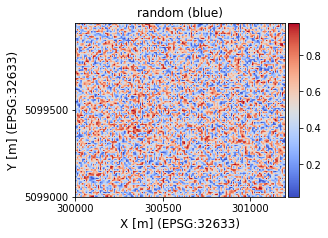

In [24]:
f = raster.plot_band('random', colormap='coolwarm')

In addition, the histogram can be visualized to check if the distribution of values in the band looks like what we expect:

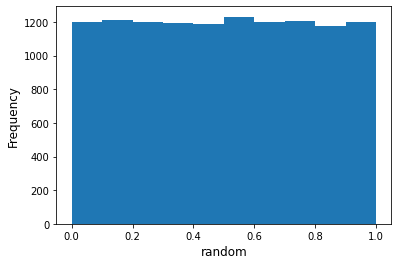

In [25]:
h = raster['blue'].hist()

## Load image data from disk

Each raster image understood by `GDAL` can be load into a `RasterCollection` using the `RasterCollection.from_multi_band_raster` class method:

In this example, a multi-band geoTiff derived from Sentinel-2 is loaded into a `RasterCollection` instance.

In [26]:
# define path to image
import os
from pathlib import Path

base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
s2_fpath = base_dir.joinpath('data/img/20190530_T32TMT_MSIL2A_S2A_pixel_division_10m.tiff')
s2_fpath.exists()

True

In its simplest form, the code is just a one-liner:

In [27]:
s2_ds = RasterCollection.from_multi_band_raster(fpath_raster=s2_fpath)
s2_ds

The `s2_ds` object can be analysed further:

In [28]:
# get band statistics
s2_ds.band_summaries()

,nanmin,nanmean,nanstd,nanmax,band_name
0,0,1184.489406,1743.451922,18128,B02
1,0,1351.206429,1627.425963,17104,B03
2,0,1207.663189,1659.893927,16432,B04
3,0,1692.144036,1649.148596,15411,B05
4,0,2988.336287,1592.478329,15825,B06
5,0,3444.154342,1665.377239,12385,B07
6,0,3656.661749,1791.248361,15616,B08
7,0,3624.300068,1690.110671,13828,B8A
8,0,2012.885961,1392.873542,15030,B11
9,0,1388.652071,1284.380238,13996,B12


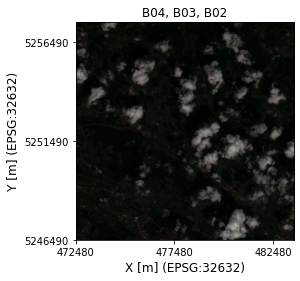

In [29]:
# plot VIS
f = s2_ds.plot_multiple_bands(['B04','B03','B02'])

## Load data from STAC (cloud-optimzed GeoTiff)

In this case we load a geoTiff from a STAC catalog provided by [SwissTopo alti3d digital terrain model](https://www.swisstopo.admin.ch/en/geodata/height/alti3d.html) into a `Band` object which we then add to an existing raster collection from Step 1:

The image data is retrieved from the STAC-URL and streamed from the server into a new `Band` instance called `dem` (internet connection required).

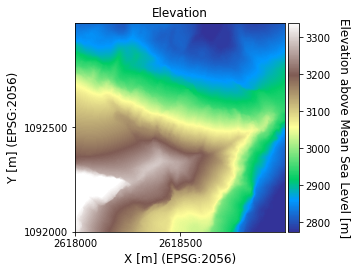

In [30]:
# link to cloud-optimized geoTiffs at Swisstopp
dem_file = 'https://data.geo.admin.ch/ch.swisstopo.swissalti3d/swissalti3d_2019_2618-1092/swissalti3d_2019_2618-1092_2_2056_5728.tif'

# load resource into a Band instance and name it "Elevation"
dem = Band.from_rasterio(fpath_raster=dem_file, band_name_dst='Elevation')

# fast visualization
fig = dem.plot(
    colormap='terrain',
    colorbar_label=f'Elevation above Mean Sea Level [m]'
)

We can now add this `Band` object to the `RasterCollection` object `raster` from Step 1 holding random values.

In [31]:
raster.add_band(band_constructor=dem)

In [32]:
# check band names
raster.band_names

['random', 'Elevation']

This highlights the unique capacity of `EOdal` to handle very diverse data sources (different geographic locations, data types, spatial extents, etc.) within a single `RasterCollection` instance.